In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg

## No BC

Poisson's equation:

$\triangledown^2 u + f(x, y) = 0$

$\Rightarrow $

$\mathbf{A}\mathbf{u}+\mathbf{f}=0$

In [2]:
Nx = 100
Ny = 100
dx = 0.01
dy = 0.01

In [3]:
A = sparse.eye(Nx*Ny) * (-2/dx**2 + -2/dy**2)
A += sparse.eye(Nx*Ny, k=1) / dx**2
A += sparse.eye(Nx*Ny, k=-1) / dx**2
A += sparse.eye(Nx*Ny, k=Nx) / dy**2
A += sparse.eye(Nx*Ny, k=-Nx) / dy**2

A = A.toarray()
for i in range(1, Ny):
    A[Nx*i-1, Nx*i] = 0
    A[Nx*i, Nx*i-1] = 0
    
A = sparse.csc_matrix(A)

In [4]:
f = np.ones((Nx*Ny, 1))

In [5]:
u = linalg.spsolve(A, -f)

(0.0, 1.0, 0.0, 1.0)

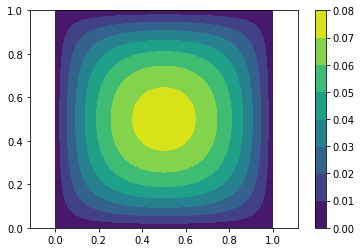

In [6]:
ua = np.reshape(u, (Ny, Nx))

X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))
plt.contourf(X, Y, ua)
plt.colorbar()
plt.axis('equal')

-----
This method does not consider the boundary.
Actually, it is equivalent to the Dirichlet boundary problem with larger domain size (Nx+2) * (Ny+2), and the boundary values are all 0.

## With Dirichlet BC

Poisson's equation:

$\triangledown^2 u = f(x, y)$

$\Rightarrow $

$\mathbf{A}\mathbf{u}+\mathbf{b_{c}}=\mathbf{f}$

In [7]:
Nx = 100
Ny = 100
dx = 0.01
dy = 0.01

# boundary condition
u_b = 0   # bottom, scaler or array with size (Nx-2)
u_t = 0   # top, scaler or array with size (Nx-2)
u_l = 0   # left, scaler or array with size (Ny-2)
u_r = 0   # right, scaler or array with size (Ny-2)

In [8]:
size = (Nx-2) * (Ny-2)
A = sparse.eye(size) * (-2/dx**2 + -2/dy**2)
A += sparse.eye(size, k=1) / dx**2
A += sparse.eye(size, k=-1) / dx**2
A += sparse.eye(size, k=Nx-2) / dy**2
A += sparse.eye(size, k=-Nx+2) / dy**2

A = A.toarray()
for i in range(1, Ny-2):
    A[(Nx-2)*i-1, (Nx-2)*i] = 0
    A[(Nx-2)*i, (Nx-2)*i-1] = 0
    
A = sparse.csc_matrix(A)

bc1 = np.zeros((size, 1))
bc1[:(Nx-2)] = u_b
bc1[-(Nx-2):] = u_t
bc2 = np.zeros((Ny-2, Nx-2))
bc2[:,0] = u_l
bc2[:,-1] = u_r
bc2 = np.reshape(bc2, (size, 1))
bc = bc1 / dy**2 + bc2 / dx**2

In [9]:
f = -1 * np.ones((size, 1))

In [10]:
u = linalg.spsolve(A, f-bc)

(0.0, 1.0, 0.0, 1.0)

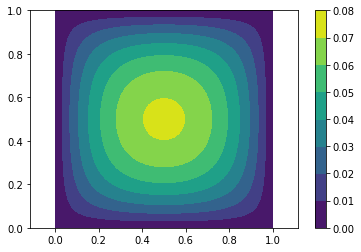

In [11]:
ua = np.reshape(u, (Ny-2, Nx-2))
bc_b = np.zeros((1, Nx-2)) + u_b
bc_t = np.zeros((1, Nx-2)) + u_t
bc_l = np.zeros((Ny-2, 1)) + u_l
bc_r = np.zeros((Ny-2, 1)) + u_r
ua = np.block([
    [bc_b[0,0], bc_b, bc_b[0,-1]], 
    [bc_l, ua, bc_r], 
    [bc_t[0,0], bc_t, bc_t[0,-1]]
])

X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))
plt.contourf(X, Y, ua)
plt.colorbar()
plt.axis('equal')

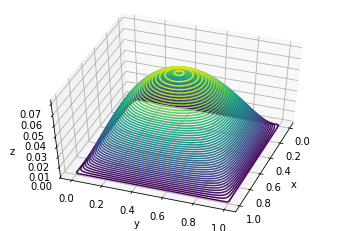

In [12]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, ua, 50)
ax.view_init(50, 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Function

In [13]:
def solve_2D_poisson_fd(Nx, Ny, dx, dy, f, u_b=0, u_t=0, u_l=0, u_r=0):
    """
    Solve 2D poisson's equation with Dirichlet boundary problem 
    by finite difference method.
    
    Parameters:
    ----------
    Nx, Ny: int
        Grids number.
    dx, dy: scaler
        Resolution.
    f: 1-d array with size=(Nx-2)*(Ny-2), or 2-d array with size=(Ny-2, Nx-2)
        The right hand side of poisson equation.
        The boundary of 'f' is not necessary, thus reducing the size from
        (Ny, Nx) to (Ny-2, Nx-2).
    u_b, u_t: scaler or 1-d array with size=(Nx-2)
        The dirichlet boundary condition of bottom and top side.
        Default is 0.
    u_l, u_r: scaler or 1-d array with size=(Ny-2)
        The dirichlet boundary condition of left and right side.
        Default is 0.
        
    Return:
    ------
    ua: 2-d array, shape=(Ny, Nx).
        The solution of poisson's equation.
        Values of ua[0,:], ua[-1,:], ua[:,0], ua[:,-1] would equal to the boundary
        condition: u_b, u_t, u_l and u_r.
    """    
    # A*u + bc = f
    
    # convert boundary condition first
    if isinstance(u_b, np.ndarray):
        u_b = u_b.reshape((1, Nx-2))
    elif isinstance(u_b, (int, float)):
        u_b = np.ones((1, Nx-2)) * u_b

    if isinstance(u_t, np.ndarray):
        u_t = u_t.reshape((1, Nx-2))
    elif isinstance(u_t, (int, float)):
        u_t = np.ones((1, Nx-2)) * u_t
        
    if isinstance(u_l, np.ndarray):
        u_l = u_l.reshape((Ny-2, 1))
    elif isinstance(u_l, (int, float)):
        u_l = np.ones((Ny-2, 1)) * u_l
        
    if isinstance(u_r, np.ndarray):
        u_r = u_r.reshape((Ny-2, 1))
    elif isinstance(u_r, (int, float)):
        u_r = np.ones((Ny-2, 1)) * u_r
        
    f = np.reshape(f, ((Nx-2)*(Ny-2), 1))
    
    # build A matrix
    size = (Nx-2) * (Ny-2)
    A = sparse.eye(size) * (-2/dx**2 + -2/dy**2)
    A += sparse.eye(size, k=1) / dx**2
    A += sparse.eye(size, k=-1) / dx**2
    A += sparse.eye(size, k=Nx-2) / dy**2
    A += sparse.eye(size, k=-Nx+2) / dy**2

    A = A.toarray()
    for i in range(1, Ny-2):
        A[(Nx-2)*i-1, (Nx-2)*i] = 0
        A[(Nx-2)*i, (Nx-2)*i-1] = 0

    A = sparse.csc_matrix(A)

    # build bc vector
    bc1 = np.zeros((size, 1))
    bc1[:(Nx-2)] = u_b.reshape((-1, 1))
    bc1[-(Nx-2):] = u_t.reshape((-1, 1))
    
    bc2 = np.zeros((Ny-2, Nx-2))
    bc2[:,0] = u_l.reshape((1, -1))
    bc2[:,-1] = u_r.reshape((1, -1))
    bc2 = np.reshape(bc2, (size, 1))
    
    bc = bc1 / dy**2 + bc2 / dx**2
    
    # solve u
    u = linalg.spsolve(A, f-bc)
    
    # convert u vector to 2-d array, and concatenate the boundary part
    ua = np.reshape(u, (Ny-2, Nx-2))
    bc_b = np.zeros((1, Nx-2)) + u_b
    bc_t = np.zeros((1, Nx-2)) + u_t
    bc_l = np.zeros((Ny-2, 1)) + u_l
    bc_r = np.zeros((Ny-2, 1)) + u_r
    ua = np.block([
        [bc_b[0,0], bc_b, bc_b[0,-1]], 
        [bc_l, ua, bc_r], 
        [bc_t[0,0], bc_t, bc_t[0,-1]]
    ])
    
    return ua

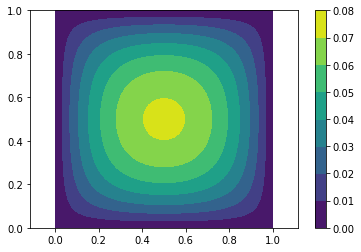

In [14]:
Nx = 100
Ny = 100
dx = 0.01
dy = 0.01
f = -1 * np.ones(((Nx-2)*(Ny-2), 1))

ua = solve_2D_poisson_fd(Nx, Ny, dx, dy, f)
X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))
plt.contourf(X, Y, ua)
plt.colorbar()
plt.axis('equal');

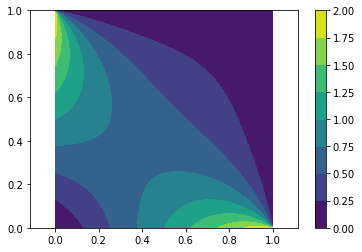

In [15]:
Nx = 100
Ny = 100
dx = 0.01
dy = 0.01
f = -1 * np.ones(((Nx-2)*(Ny-2), 1))

ua = solve_2D_poisson_fd(
    Nx, Ny, dx, dy, f, 
    np.linspace(0, 2, 98), 
    0, 
    np.linspace(0, 2, 98), 
    0
)
X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))
plt.contourf(X, Y, ua)
plt.colorbar()
plt.axis('equal');